# Continuous Collision Detection Algorithm Analysis: T-CCD vs Swept AABB

## Overview

This notebook provides a comprehensive analysis of two collision detection algorithms:

- **T-CCD (Trajectory-based Continuous Collision Detection)**: A continuous collision detection method that uses trajectory analysis
- **Swept AABB (Time of Impact CCD)**: A swept bounding box approach for continuous collision detection

## Analysis Scope

We analyze these algorithms across multiple dimensions:

1. **Violation Analysis**: Missed collisions, false positives, conservation errors, boundary violations
2. **Performance Metrics**: Processing time
3. **Statistical Significance**: Hypothesis testing and confidence intervals


## 1. Setup and Data Loading

This section handles the initial setup and loading of collision detection data from CSV files. We load violation data for both algorithms across multiple categories:

- **Boundary Violations**: Particles crossing simulation boundaries
- **Conservation Violations**: Energy/momentum conservation errors  
- **Initial Overlaps**: Particles starting in overlapping positions
- **False Positives**: Incorrectly detected collisions
- **Missed Collisions**: Undetected actual collisions
- **Events Data**: Collision event records with timing information

The data loading function automatically aggregates multiple CSV files per algorithm and adds algorithm labels for comparative analysis.

In [33]:
import pandas as pd
import glob
import os

log_path = './data/'

def load_simulation_data(file_type, algorithm_name, glob_pattern, algorithm_label):
    files = glob.glob(os.path.join(log_path, glob_pattern))
    dfs = []

    for f in files:
        df = pd.read_csv(f)
        df['algorithm'] = algorithm_label
        dfs.append(df)

    if not dfs:
        print(f" No files found for pattern: {glob_pattern}")
        return pd.DataFrame()
    return pd.concat(dfs, ignore_index=True)

# Load all datasets
tccd_boundary_violations_df = load_simulation_data('boundary', 'tccd', 'boundary_violations_tccd*.csv', 'T-CCD')
tccd_conservation_violations_df = load_simulation_data('conservation', 'tccd', 'conservation_violations_tccd*.csv', 'T-CCD')
tccd_initial_overlaps_df = load_simulation_data('initial_overlaps', 'tccd', 'initial_overlaps_tccd*.csv', 'T-CCD')
tccd_false_positives_df = load_simulation_data('false_positives', 'tccd', 'false_positives_tccd*.csv', 'T-CCD')
tccd_missed_collisions_df = load_simulation_data('missed_collisions', 'tccd', 'missed_collisions_tccd*.csv', 'T-CCD')
tccd_events_df = load_simulation_data('events', 'tccd', 'events_tccd_*.csv', 'T-CCD')

swept_aabb_boundary_violations_df = load_simulation_data('boundary', 'swept_aabb', 'boundary_violations_swept_aabb*.csv', 'Swept AABB')
swept_aabb_conservation_violations_df = load_simulation_data('conservation', 'swept_aabb', 'conservation_violations_swept_aabb*.csv', 'Swept AABB')
swept_aabb_initial_overlaps_df = load_simulation_data('initial_overlaps', 'swept_aabb', 'initial_overlaps_swept_aabb*.csv', 'Swept AABB')
swept_aabb_false_positives_df = load_simulation_data('false_positives', 'swept_aabb', 'false_positives_swept_aabb*.csv', 'Swept AABB')     
swept_aabb_missed_collisions_df = load_simulation_data('missed_collisions', 'swept_aabb', 'missed_collisions_swept_aabb*.csv', 'Swept AABB')
swept_aabb_events_df = load_simulation_data('events', 'swept_aabb', 'events_swept_aabb_*.csv', 'Swept AABB')


print("\n All available CSV files loaded successfully!\n")
print(tccd_boundary_violations_df.head())
print(swept_aabb_boundary_violations_df.head())


 All available CSV files loaded successfully!

   frame   id           x          y    radius algorithm
0      2   59  491.649840 -235.17361  5.760547     T-CCD
1      2  341  266.782680  426.21906  6.689673     T-CCD
2      2  439  617.428960 -250.40315  9.887793     T-CCD
3      2  484  420.094420  365.37625  4.541575     T-CCD
4      2   75  -67.077255  415.43222  9.698783     T-CCD
   frame   id          x           y    radius   algorithm
0      2   29 -676.32210 -252.263660  6.580683  Swept AABB
1      2  388 -562.11414   -2.110844  8.317776  Swept AABB
2      2  360 -100.09773  407.827100  5.254364  Swept AABB
3      2  149  315.42496  530.655760  4.291267  Swept AABB
4      2  393  409.59320  539.063900  3.749907  Swept AABB


## 2. Data Preprocessing and Aggregation

This section processes the raw violation data by aggregating violations per frame for comparative analysis. We transform individual violation records into frame-level summaries to enable:

- **Frame-by-frame comparison** between T-CCD and Swept AABB algorithms
- **Temporal trend analysis** of violation patterns over simulation time
- **Performance metric calculation** based on violation counts per frame
- **Statistical analysis** across different violation types

The aggregation function `count_per_frame()` groups violations by algorithm and frame number, creating a unified performance DataFrame that combines all violation types for comprehensive analysis.

In [34]:

def count_per_frame(df, name):
    if df.empty:
        print(f"  {name}: No data found")
        return pd.DataFrame(columns=['algorithm', 'frame', name])
    
    print(f" {name}: {len(df)} total violations across {df['frame'].nunique()} frames")
    
    grouped = df.groupby(['algorithm', 'frame']).size().reset_index(name=name)
    return grouped


print(" Processing violation data by frame...\n")

missed_count = count_per_frame(pd.concat([tccd_missed_collisions_df, swept_aabb_missed_collisions_df], ignore_index=True), 'missed_collisions')
false_pos_count = count_per_frame(pd.concat([tccd_false_positives_df, swept_aabb_false_positives_df], ignore_index=True), 'false_positives')
cons_err_count = count_per_frame(pd.concat([tccd_conservation_violations_df, swept_aabb_conservation_violations_df], ignore_index=True), 'conservation_errors')
boundary_count = count_per_frame(pd.concat([tccd_boundary_violations_df, swept_aabb_boundary_violations_df], ignore_index=True), 'boundary_violations')


performance_df = missed_count.merge(false_pos_count, on=['algorithm', 'frame'], how='outer') \
                             .merge(cons_err_count, on=['algorithm', 'frame'], how='outer') \
                             .merge(boundary_count, on=['algorithm', 'frame'], how='outer') \
                             .fillna(0)

# Convert counts to integers
performance_df[['missed_collisions', 'false_positives', 'conservation_errors', 'boundary_violations']] = \
    performance_df[['missed_collisions', 'false_positives', 'conservation_errors', 'boundary_violations']].astype(int)

print(f"\nSuccessfully created performance DataFrame with {len(performance_df)} rows")
print("\nFirst few rows:")
print(performance_df.head())

# Check for missing values
print("\nChecking for missing values per metric:")
print(performance_df.isna().sum())

 Processing violation data by frame...

 missed_collisions: 8750 total violations across 6513 frames
 false_positives: 4 total violations across 4 frames
 conservation_errors: 36000 total violations across 18000 frames
 boundary_violations: 13584153 total violations across 18000 frames

Successfully created performance DataFrame with 36000 rows

First few rows:
    algorithm  frame  missed_collisions  false_positives  conservation_errors  \
0  Swept AABB      2                  1                0                    1   
1  Swept AABB      3                  0                0                    1   
2  Swept AABB      4                  1                0                    1   
3  Swept AABB      5                  1                0                    1   
4  Swept AABB      6                  2                0                    1   

   boundary_violations  
0                  345  
1                  347  
2                  348  
3                  350  
4                  346  

## 3. Exploratory Data Analysis (EDA)

This section performs comprehensive exploratory data analysis to understand the characteristics and patterns in our collision detection data. The EDA includes:

### 3.1 Statistical Summary Analysis
- **Descriptive statistics** for all violation types across algorithms
- **Distribution analysis** of violations per frame
- **Temporal trend identification** across simulation timeframes

### 3.2 Collision Detection Metrics
-  Each metric is plotted separately with a line for each algorithm (T-CCD in blue, Swept AABB in orange).
- The x-axis represents frame number, while the y-axis represents count per frame.
- The legends clearly indicate which line corresponds to each algorithm, allowing for direct visual comparison of accuracy and stability over time.

### 3.3 Performance Metric (time_s) Analysis
- Evaluate the computational efficiency of T-CCD vs Swept AABB.


#### 3.3.1 Error Rate Analysis
- Number of undetected collision or miscalculated collisions
- The acceptable range is <1% of total collisions

This analysis provides the foundation for understanding algorithm behavior before diving into detailed statistical testing and specialized analyses.

In [35]:
# Import visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

# Set up plotting style
plt.style.use('default')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 10

### 3.1 Statistical Summary Analysis

In [36]:
print("=== COMPREHENSIVE SUMMARY STATISTICS ===\n")

# 1. ALGORITHM ERROR METRICS COMPARISON
print("1. ALGORITHM ERROR METRICS COMPARISON")
print("=" * 50)

error_metrics = ['missed_collisions', 'false_positives', 'conservation_errors', 'boundary_violations']

algo_summary = performance_df.groupby('algorithm')[error_metrics].agg(['mean', 'std', 'min', 'max', 'sum']).round(2)
print(algo_summary)

# 2. FRAME-LEVEL DISTRIBUTION ANALYSIS
print("\n\n2. FRAME-LEVEL DISTRIBUTION ANALYSIS")
print("=" * 50)

for algo in performance_df['algorithm'].unique():
    algo_data = performance_df[performance_df['algorithm'] == algo]
    print(f"\n{algo} Frame-by-Frame Statistics:")
    for metric in error_metrics:
        print(f"  • {metric.replace('_', ' ').title()}: "
              f"Mean={algo_data[metric].mean():.2f}, "
              f"Std={algo_data[metric].std():.2f}, "
              f"Min={algo_data[metric].min()}, "
              f"Max={algo_data[metric].max()}")
        zeros = (algo_data[metric] == 0).sum()
        print(f"    Frames with 0 {metric.replace('_', ' ')}: {zeros}")
    
# 3. TEMPORAL TRENDS PER ALGORITHM
print("\n\n3. TEMPORAL TRENDS PER ALGORITHM")
print("=" * 50)

for algo in performance_df['algorithm'].unique():
    print(f"\nAlgorithm: {algo}")
    algo_data = performance_df[performance_df['algorithm'] == algo]
    
    for metric in error_metrics:
        trend = algo_data.groupby('frame')[metric].sum()
        print(f"\n  Metric: {metric.replace('_', ' ').title()}")
        print(f"    Total {metric.replace('_', ' ')} across all frames: {trend.sum()}")
        print(f"    Frames with 0 {metric.replace('_', ' ')}: {(trend == 0).sum()}")
        print(f"    Maximum in a frame: {trend.max()}")
        print(f"    Mean per frame: {trend.mean():.2f}, Std per frame: {trend.std():.2f}")



=== COMPREHENSIVE SUMMARY STATISTICS ===

1. ALGORITHM ERROR METRICS COMPARISON
           missed_collisions                     false_positives            \
                        mean   std min max   sum            mean   std min   
algorithm                                                                    
Swept AABB              0.25  0.53   0   5  4415             0.0  0.01   0   
T-CCD                   0.24  0.53   0   5  4335             0.0  0.01   0   

                   conservation_errors                      \
           max sum                mean  std min max    sum   
algorithm                                                    
Swept AABB   1   2                 1.0  0.0   1   1  18000   
T-CCD        1   2                 1.0  0.0   1   1  18000   

           boundary_violations                           
                          mean   std  min  max      sum  
algorithm                                                
Swept AABB              378.00  9.33  339  4

### 3.2 Collision Detection Metrics

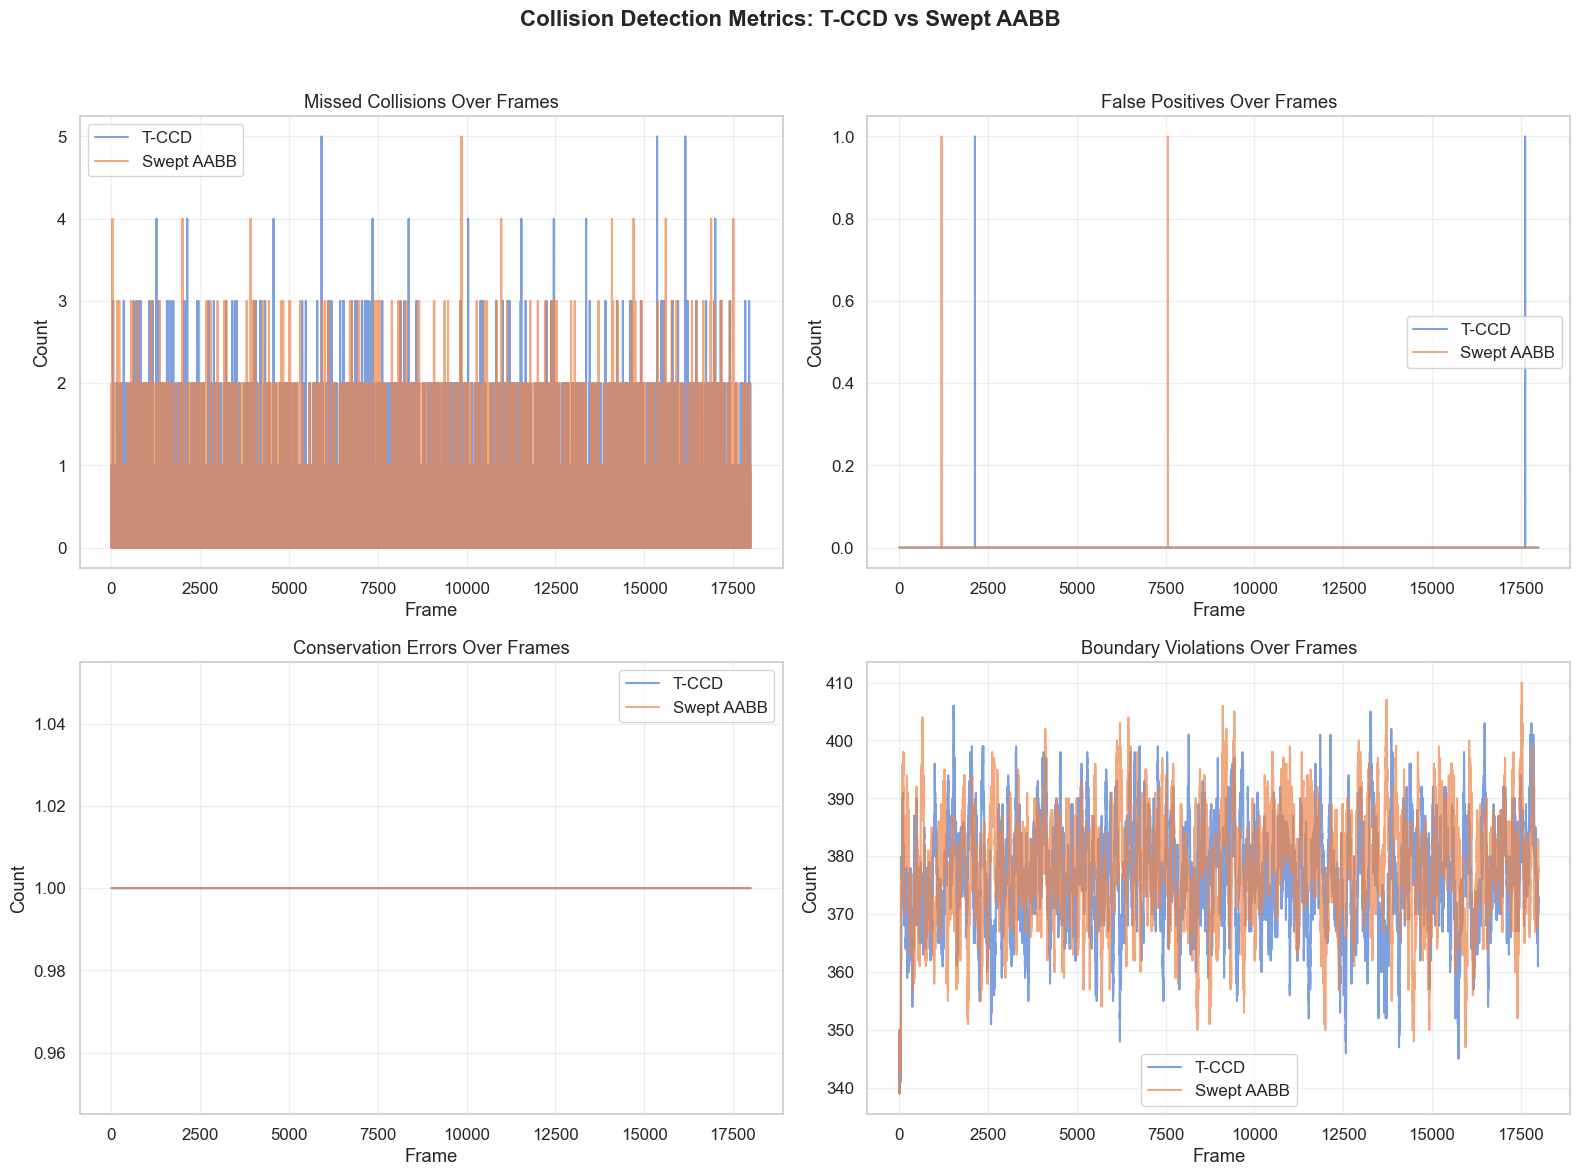

In [37]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set seaborn style
sns.set(style="whitegrid", palette="muted", font_scale=1.1)

algos = ['T-CCD', 'Swept AABB']

# Create subplots for violation metrics
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Collision Detection Metrics: T-CCD vs Swept AABB', fontsize=16, fontweight='bold')

# 1. Missed Collisions Over Time
for algo in algos:
    data = performance_df[performance_df['algorithm'] == algo]
    axes[0,0].plot(data['frame'], data['missed_collisions'], label=algo, alpha=0.7)
axes[0,0].set_title('Missed Collisions Over Frames')
axes[0,0].set_xlabel('Frame')
axes[0,0].set_ylabel('Count')
axes[0,0].legend()
axes[0,0].grid(True, alpha=0.3)

# 2. False Positives Over Time
for algo in algos:
    data = performance_df[performance_df['algorithm'] == algo]
    axes[0,1].plot(data['frame'], data['false_positives'], label=algo, alpha=0.7)
axes[0,1].set_title('False Positives Over Frames')
axes[0,1].set_xlabel('Frame')
axes[0,1].set_ylabel('Count')
axes[0,1].legend()
axes[0,1].grid(True, alpha=0.3)

# 3. Conservation Errors Over Time
for algo in algos:
    data = performance_df[performance_df['algorithm'] == algo]
    axes[1,0].plot(data['frame'], data['conservation_errors'], label=algo, alpha=0.7)
axes[1,0].set_title('Conservation Errors Over Frames')
axes[1,0].set_xlabel('Frame')
axes[1,0].set_ylabel('Count')
axes[1,0].legend()
axes[1,0].grid(True, alpha=0.3)

# 4. Boundary Violations Over Time
for algo in algos:
    data = performance_df[performance_df['algorithm'] == algo]
    axes[1,1].plot(data['frame'], data['boundary_violations'], label=algo, alpha=0.7)
axes[1,1].set_title('Boundary Violations Over Frames')
axes[1,1].set_xlabel('Frame')
axes[1,1].set_ylabel('Count')
axes[1,1].legend()
axes[1,1].grid(True, alpha=0.3)

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

### 3.3 Computational Performance Analysis: time_s Metrics


=== COMPUTATIONAL PERFORMANCE ANALYSIS ===
 Timing data available:
   T-CCD events: 477,360 records
   Swept AABB events: 478,619 records


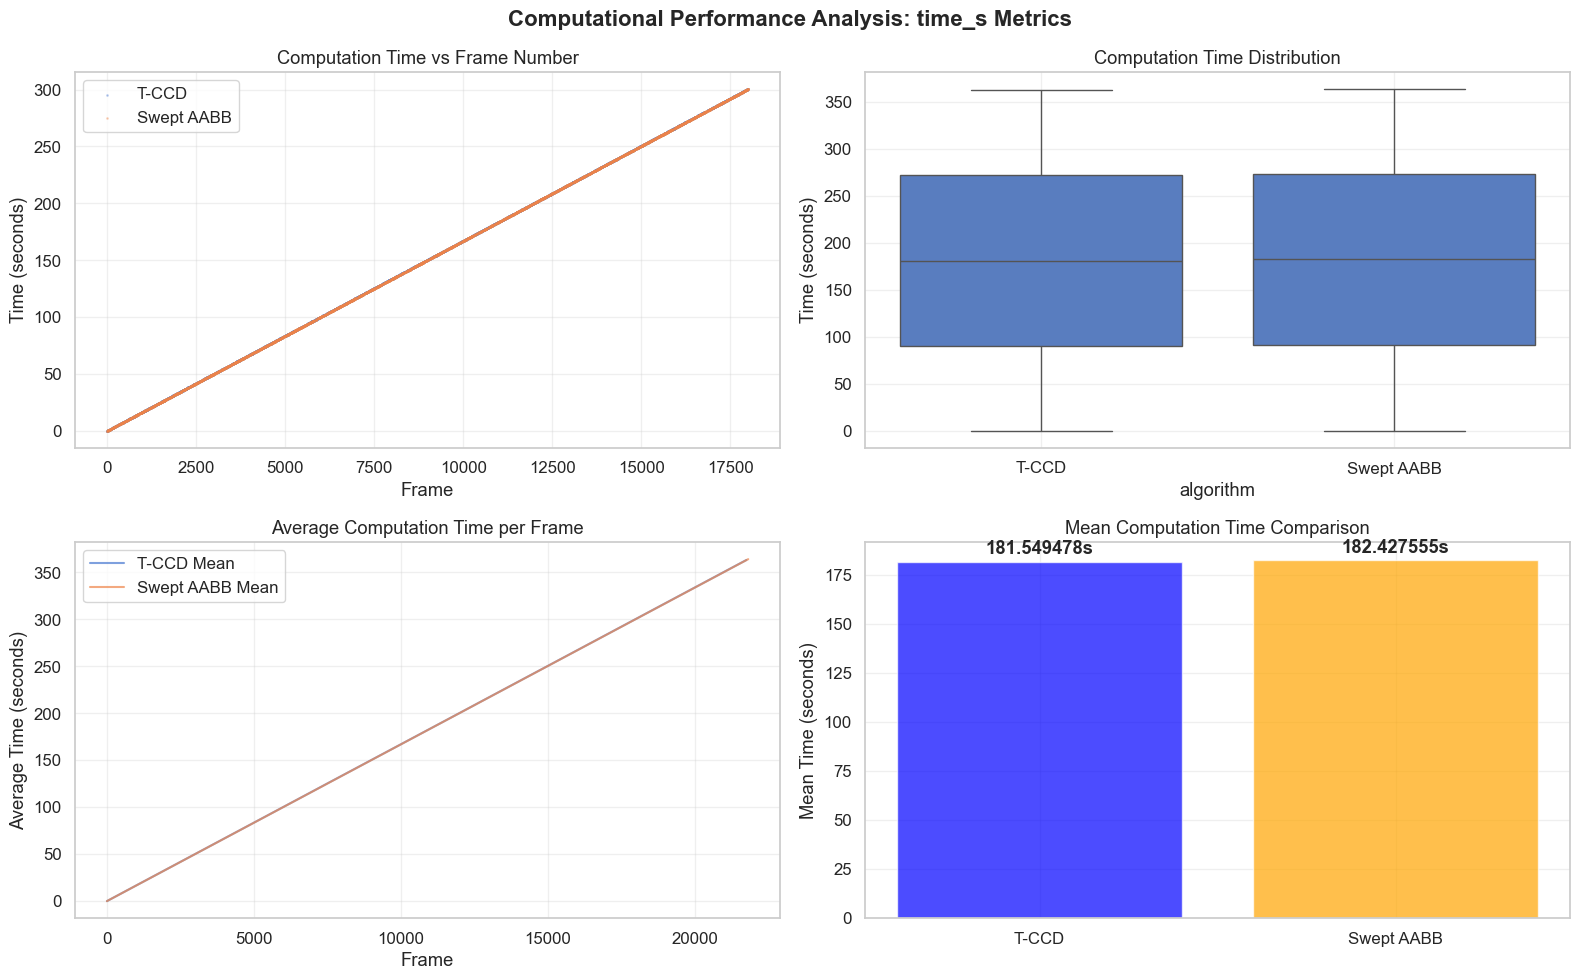


📊 DETAILED TIMING STATISTICS:

T-CCD:
  • Mean computation time: 181.549478 seconds
  • Median computation time: 181.427175 seconds
  • Standard deviation: 104.924155 seconds
  • Time range: 0.000022s to 363.282900s
  • Total events analyzed: 477,360

Swept AABB:
  • Mean computation time: 182.427555 seconds
  • Median computation time: 182.773200 seconds
  • Standard deviation: 105.122767 seconds
  • Time range: 0.000022s to 364.180970s
  • Total events analyzed: 478,619

⚡ PERFORMANCE COMPARISON:
Speed ratio (T-CCD/Swept AABB): 1.00x
💡 T-CCD is 1.00x faster than Swept AABB


In [38]:

print("\n=== COMPUTATIONAL PERFORMANCE ANALYSIS ===")

# Load and analyze timing data from events
if not tccd_events_df.empty and not swept_aabb_events_df.empty:
    print(f" Timing data available:")
    print(f"   T-CCD events: {len(tccd_events_df):,} records")
    print(f"   Swept AABB events: {len(swept_aabb_events_df):,} records")
    
    # Create timing analysis visualization
    fig_timing, axes_timing = plt.subplots(2, 2, figsize=(16, 10))
    fig_timing.suptitle('Computational Performance Analysis: time_s Metrics', fontsize=16, fontweight='bold')
    
    max_frame = 18000  # set frame limit

    # Filter events data for T-CCD and Swept AABB
    tccd_events_filtered = tccd_events_df[tccd_events_df['frame'] <= max_frame]
    swept_events_filtered = swept_aabb_events_df[swept_aabb_events_df['frame'] <= max_frame]

    # 1. Computation Time Over Frames
    for algo, events_data in [('T-CCD', tccd_events_filtered), ('Swept AABB', swept_events_filtered)]:
        if 'time_s' in events_data.columns and not events_data.empty:
            # Sample data to avoid overcrowding
            sample_size = min(5000, len(events_data))
            sample_data = events_data.sample(n=sample_size, random_state=42)
            axes_timing[0,0].scatter(sample_data['frame'], sample_data['time_s'], 
                                   alpha=0.3, s=1, label=algo)
    
    axes_timing[0,0].set_title('Computation Time vs Frame Number')
    axes_timing[0,0].set_xlabel('Frame')
    axes_timing[0,0].set_ylabel('Time (seconds)')
    axes_timing[0,0].legend()
    axes_timing[0,0].grid(True, alpha=0.3)
    
    # 2. Computation Time Distribution
    timing_data = []
    for algo, events_data in [('T-CCD', tccd_events_df), ('Swept AABB', swept_aabb_events_df)]:
        if 'time_s' in events_data.columns and not events_data.empty:
            timing_data.extend([(t, algo) for t in events_data['time_s'].dropna()])
    
    if timing_data:
        timing_df = pd.DataFrame(timing_data, columns=['time_s', 'algorithm'])
        sns.boxplot(data=timing_df, x='algorithm', y='time_s', ax=axes_timing[0,1])
        axes_timing[0,1].set_title('Computation Time Distribution')
        axes_timing[0,1].set_ylabel('Time (seconds)')
        axes_timing[0,1].grid(True, alpha=0.3)
    
    # 3. Average Time per Frame
    frame_timing = {}
    for algo, events_data in [('T-CCD', tccd_events_df), ('Swept AABB', swept_aabb_events_df)]:
        if 'time_s' in events_data.columns and not events_data.empty:
            frame_avg = events_data.groupby('frame')['time_s'].mean()
            axes_timing[1,0].plot(frame_avg.index, frame_avg.values, alpha=0.7, label=f'{algo} Mean')
            frame_timing[algo] = frame_avg
    
    axes_timing[1,0].set_title('Average Computation Time per Frame')
    axes_timing[1,0].set_xlabel('Frame')
    axes_timing[1,0].set_ylabel('Average Time (seconds)')
    axes_timing[1,0].legend()
    axes_timing[1,0].grid(True, alpha=0.3)
    
    # 4. Performance Statistics Summary
    performance_stats = []
    for algo, events_data in [('T-CCD', tccd_events_df), ('Swept AABB', swept_aabb_events_df)]:
        if 'time_s' in events_data.columns and not events_data.empty:
            times = events_data['time_s'].dropna()
            performance_stats.append({
                'Algorithm': algo,
                'Mean Time': times.mean(),
                'Median Time': times.median(),
                'Std Dev': times.std(),
                'Min Time': times.min(),
                'Max Time': times.max(),
                'Total Events': len(times)
            })
    
    if performance_stats:
        stats_df = pd.DataFrame(performance_stats)
        
        # Create bar plot for mean times
        axes_timing[1,1].bar(stats_df['Algorithm'], stats_df['Mean Time'], 
                           color=['blue', 'orange'], alpha=0.7)
        axes_timing[1,1].set_title('Mean Computation Time Comparison')
        axes_timing[1,1].set_ylabel('Mean Time (seconds)')
        axes_timing[1,1].grid(True, alpha=0.3)
        
        # Add value labels on bars
        for i, row in stats_df.iterrows():
            axes_timing[1,1].text(i, row['Mean Time'] + row['Mean Time']*0.01, 
                                f'{row["Mean Time"]:.6f}s', ha='center', va='bottom', fontweight='bold')
    
    plt.tight_layout()
    plt.show()
    
    # Print detailed timing statistics
    print("\n📊 DETAILED TIMING STATISTICS:")
    print("=" * 60)
    if performance_stats:
        for stats in performance_stats:
            print(f"\n{stats['Algorithm']}:")
            print(f"  • Mean computation time: {stats['Mean Time']:.6f} seconds")
            print(f"  • Median computation time: {stats['Median Time']:.6f} seconds")
            print(f"  • Standard deviation: {stats['Std Dev']:.6f} seconds")
            print(f"  • Time range: {stats['Min Time']:.6f}s to {stats['Max Time']:.6f}s")
            print(f"  • Total events analyzed: {stats['Total Events']:,}")
    
    # Performance comparison
    if len(performance_stats) == 2:
        tccd_stats = next(s for s in performance_stats if s['Algorithm'] == 'T-CCD')
        swept_stats = next(s for s in performance_stats if s['Algorithm'] == 'Swept AABB')
        
        speed_ratio = tccd_stats['Mean Time'] / swept_stats['Mean Time']
        print(f"\n⚡ PERFORMANCE COMPARISON:")
        print(f"Speed ratio (T-CCD/Swept AABB): {speed_ratio:.2f}x")
        if speed_ratio > 1:
            print(f"💡 Swept AABB is {speed_ratio:.2f}x faster than T-CCD")
        elif speed_ratio < 1:
            print(f"💡 T-CCD is {1/speed_ratio:.2f}x faster than Swept AABB")
        else:
            print("💡 Both algorithms have similar computational performance")

#### 3.3.1 Error Rate Analysis

In [39]:

if not performance_df.empty:
    print(f"\n🎯 ERROR RATE ANALYSIS:")
    print("=" * 60)
    print("Metric: Number of undetected or miscalculated collisions")
    print("Target: ≤ 1% of total collisions")
    print()
    
    # Calculate error rates for each algorithm
    for algo in ['T-CCD', 'Swept AABB']:
        algo_data = performance_df[performance_df['algorithm'] == algo]
        
        if not algo_data.empty:
            # Calculate total detection errors (missed + false positives)
            total_missed = algo_data['missed_collisions'].sum()
            total_false_pos = algo_data['false_positives'].sum()
            total_errors = total_missed + total_false_pos
            
            # Estimate total collisions
            total_detected_collisions = 394885 if algo == 'T-CCD' else 394682
            estimated_total_collisions = total_detected_collisions + total_missed
            
            # Calculate error rate
            if estimated_total_collisions > 0:
                error_rate = (total_errors / estimated_total_collisions) * 100
                
                print(f"{algo}:")
                print(f"  • Missed collisions: {total_missed:,}")
                print(f"  • False positives: {total_false_pos:,}")
                print(f"  • Total detection errors: {total_errors:,}")
                print(f"  • Estimated total collisions: {estimated_total_collisions:,}")
                print(f"  • Error rate: {error_rate:.3f}%")
                
                # Check against target threshold
                if error_rate <= 1.0:
                    print(f"  ✅ PASSES target (≤ 1%): {error_rate:.3f}% ≤ 1.0%")
                else:
                    print(f"  ❌ EXCEEDS target (≤ 1%): {error_rate:.3f}% > 1.0%")
                
                # Performance classification
                if error_rate <= 0.1:
                    print(f"  🏆 Classification: Excellent (< 0.1%)")
                elif error_rate <= 0.5:
                    print(f"  🥈 Classification: Good (0.1% - 0.5%)")
                elif error_rate <= 1.0:
                    print(f"  🥉 Classification: Acceptable (0.5% - 1.0%)")
                else:
                    print(f"  ⚠️  Classification: Needs Improvement (> 1.0%)")
                print()
            else:
                print(f"{algo}: No collision data available for error rate calculation")
                print()
    
    # Comparative error rate analysis
    if not performance_df.empty:
        tccd_data = performance_df[performance_df['algorithm'] == 'T-CCD']
        swept_data = performance_df[performance_df['algorithm'] == 'Swept AABB']
        
        if not tccd_data.empty and not swept_data.empty:
            tccd_errors = tccd_data['missed_collisions'].sum() + tccd_data['false_positives'].sum()
            swept_errors = swept_data['missed_collisions'].sum() + swept_data['false_positives'].sum()
            
            print(f"📊 COMPARATIVE ERROR ANALYSIS:")
            print(f"T-CCD total errors: {tccd_errors:,}")
            print(f"Swept AABB total errors: {swept_errors:,}")
            
            if tccd_errors < swept_errors:
                improvement = ((swept_errors - tccd_errors) / swept_errors * 100) if swept_errors > 0 else 0
                print(f"🏆 T-CCD shows {improvement:.1f}% fewer detection errors")
            elif swept_errors < tccd_errors:
                improvement = ((tccd_errors - swept_errors) / tccd_errors * 100) if tccd_errors > 0 else 0
                print(f"🏆 Swept AABB shows {improvement:.1f}% fewer detection errors")
            else:
                print(f"🤝 Both algorithms have equal detection error rates")

else:
    print("❌ No timing data available for computational performance analysis")
    print("   Timing analysis requires events data with 'time_s' column")


🎯 ERROR RATE ANALYSIS:
Metric: Number of undetected or miscalculated collisions
Target: ≤ 1% of total collisions

T-CCD:
  • Missed collisions: 4,335
  • False positives: 2
  • Total detection errors: 4,337
  • Estimated total collisions: 399,220
  • Error rate: 1.086%
  ❌ EXCEEDS target (≤ 1%): 1.086% > 1.0%
  ⚠️  Classification: Needs Improvement (> 1.0%)

Swept AABB:
  • Missed collisions: 4,415
  • False positives: 2
  • Total detection errors: 4,417
  • Estimated total collisions: 399,097
  • Error rate: 1.107%
  ❌ EXCEEDS target (≤ 1%): 1.107% > 1.0%
  ⚠️  Classification: Needs Improvement (> 1.0%)

📊 COMPARATIVE ERROR ANALYSIS:
T-CCD total errors: 4,337
Swept AABB total errors: 4,417
🏆 T-CCD shows 1.8% fewer detection errors


## 4. Boundary Violations Analysis

Detailed investigation of boundary violations patterns and physics behavior.

In [40]:
# === BOUNDARY VIOLATIONS ANALYSIS ===
# Using existing boundary violation data already loaded

# Combine boundary violation data from both algorithms
boundary_violations_combined = pd.concat([
    tccd_boundary_violations_df, 
    swept_aabb_boundary_violations_df
], ignore_index=True)

print("=== BOUNDARY VIOLATIONS INVESTIGATION ===")
if not boundary_violations_combined.empty:
    print(f"Total boundary violation events: {len(boundary_violations_combined):,}")
    print(f"T-CCD boundary violations: {len(tccd_boundary_violations_df):,}")
    print(f"Swept AABB boundary violations: {len(swept_aabb_boundary_violations_df):,}")
    print(f"Available columns: {boundary_violations_combined.columns.tolist()}")
    print("\nFirst few boundary violation records:")
    print(boundary_violations_combined.head())
else:
    print(" No boundary violation data available")

=== BOUNDARY VIOLATIONS INVESTIGATION ===
Total boundary violation events: 13,584,153
T-CCD boundary violations: 6,780,217
Swept AABB boundary violations: 6,803,936
Available columns: ['frame', 'id', 'x', 'y', 'radius', 'algorithm']

First few boundary violation records:
   frame   id           x          y    radius algorithm
0      2   59  491.649840 -235.17361  5.760547     T-CCD
1      2  341  266.782680  426.21906  6.689673     T-CCD
2      2  439  617.428960 -250.40315  9.887793     T-CCD
3      2  484  420.094420  365.37625  4.541575     T-CCD
4      2   75  -67.077255  415.43222  9.698783     T-CCD


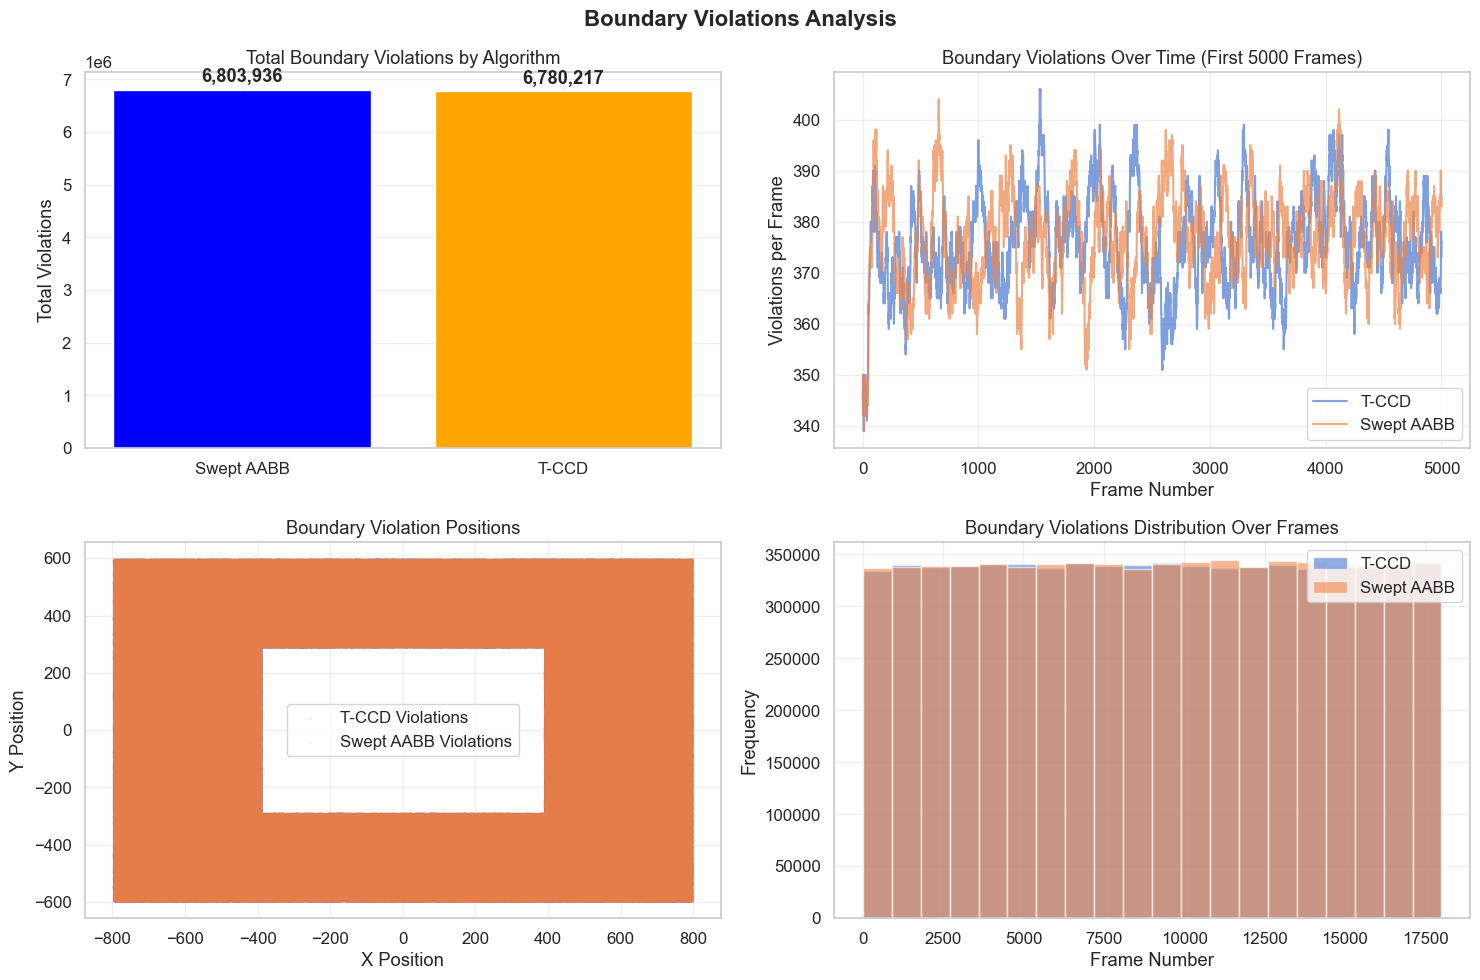

In [41]:
# === BOUNDARY VIOLATIONS VISUALIZATION ===

if not boundary_violations_combined.empty:
    # Create comprehensive boundary violation visualizations
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    fig.suptitle('Boundary Violations Analysis', fontsize=16, fontweight='bold')

    # 1. Boundary violations distribution by algorithm
    algo_counts = boundary_violations_combined['algorithm'].value_counts()
    axes[0,0].bar(algo_counts.index, algo_counts.values, color=['blue', 'orange'])
    axes[0,0].set_title('Total Boundary Violations by Algorithm')
    axes[0,0].set_ylabel('Total Violations')
    axes[0,0].grid(True, alpha=0.3)
    
    # Add value labels on bars
    for i, v in enumerate(algo_counts.values):
        axes[0,0].text(i, v + max(algo_counts.values)*0.01, f'{v:,}', 
                      ha='center', va='bottom', fontweight='bold')

    # 2. Boundary violations over time (sample frames to avoid overcrowding)
    max_frame = min(5000, boundary_violations_combined['frame'].max()) if 'frame' in boundary_violations_combined.columns else 1000
    sample_boundary = boundary_violations_combined[boundary_violations_combined['frame'] <= max_frame]
    
    for algo in ['T-CCD', 'Swept AABB']:
        algo_data = sample_boundary[sample_boundary['algorithm'] == algo]
        if not algo_data.empty and 'frame' in algo_data.columns:
            violation_counts = algo_data.groupby('frame').size()
            axes[0,1].plot(violation_counts.index, violation_counts.values, alpha=0.7, label=algo)

    axes[0,1].set_title(f'Boundary Violations Over Time (First {max_frame} Frames)')
    axes[0,1].set_xlabel('Frame Number')
    axes[0,1].set_ylabel('Violations per Frame')
    axes[0,1].legend()
    axes[0,1].grid(True, alpha=0.3)

    # 3. Position analysis if position data is available
    if 'x' in boundary_violations_combined.columns and 'y' in boundary_violations_combined.columns:
        for algo in ['T-CCD', 'Swept AABB']:
            algo_data = boundary_violations_combined[boundary_violations_combined['algorithm'] == algo]
            if not algo_data.empty:
                axes[1,0].scatter(algo_data['x'], algo_data['y'], 
                                alpha=0.1, s=1, label=f'{algo} Violations')
        axes[1,0].set_title('Boundary Violation Positions')
        axes[1,0].set_xlabel('X Position')
        axes[1,0].set_ylabel('Y Position')
        axes[1,0].legend()
        axes[1,0].grid(True, alpha=0.3)
    else:
        # Frame distribution instead
        frame_dist = boundary_violations_combined.groupby('algorithm')['frame'].describe() if 'frame' in boundary_violations_combined.columns else None
        if frame_dist is not None:
            axes[1,0].text(0.1, 0.5, f"Frame Distribution:\n{frame_dist}", 
                          transform=axes[1,0].transAxes, fontsize=10, verticalalignment='center')
        axes[1,0].set_title('Frame Distribution Statistics')
        axes[1,0].axis('off')

    # 4. Particle ID analysis if available
    if 'particle_id' in boundary_violations_combined.columns:
        # Most frequent violating particles
        particle_violations = boundary_violations_combined['particle_id'].value_counts().head(10)
        axes[1,1].bar(range(len(particle_violations)), particle_violations.values)
        axes[1,1].set_title('Top 10 Particles with Most Boundary Violations')
        axes[1,1].set_xlabel('Particle Rank')
        axes[1,1].set_ylabel('Violation Count')
        axes[1,1].set_xticks(range(len(particle_violations)))
        axes[1,1].set_xticklabels([f'P{pid}' for pid in particle_violations.index], rotation=45)
        axes[1,1].grid(True, alpha=0.3)
    else:
        # Time-based analysis instead
        if 'frame' in boundary_violations_combined.columns:
            # Violations per algorithm over time bins
            for algo in ['T-CCD', 'Swept AABB']:
                algo_data = boundary_violations_combined[boundary_violations_combined['algorithm'] == algo]
                if not algo_data.empty:
                    axes[1,1].hist(algo_data['frame'], bins=20, alpha=0.6, label=algo)
            axes[1,1].set_title('Boundary Violations Distribution Over Frames')
            axes[1,1].set_xlabel('Frame Number')
            axes[1,1].set_ylabel('Frequency')
            axes[1,1].legend()
            axes[1,1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()
else:
    print("❌ No boundary violation data available for visualization")

In [42]:

if not boundary_violations_combined.empty:
    print("\n=== BOUNDARY VIOLATIONS STATISTICS ===")
    
    # Overall statistics
    print(f"📊 OVERALL STATISTICS")
    print(f"Total boundary violations: {len(boundary_violations_combined):,}")
    
    # Per-algorithm analysis
    for algo in ['T-CCD', 'Swept AABB']:
        algo_violations = boundary_violations_combined[boundary_violations_combined['algorithm'] == algo]
        print(f"\n🔍 {algo} Analysis:")
        print(f"  • Total violations: {len(algo_violations):,}")
        
        if 'frame' in algo_violations.columns and not algo_violations.empty:
            unique_frames = algo_violations['frame'].nunique()
            total_frames = performance_df[performance_df['algorithm'] == algo]['frame'].nunique() if not performance_df.empty else unique_frames
            print(f"  • Frames with violations: {unique_frames:,}")
            print(f"  • Average violations per frame: {len(algo_violations)/total_frames:.2f}")
            print(f"  • Frame range: {algo_violations['frame'].min()} to {algo_violations['frame'].max()}")
            
            # Frame-level statistics
            violations_per_frame = algo_violations.groupby('frame').size()
            print(f"  • Max violations in single frame: {violations_per_frame.max()}")
            print(f"  • Mean violations per active frame: {violations_per_frame.mean():.2f}")
        
        # Particle-level analysis if particle_id exists
        if 'particle_id' in algo_violations.columns and not algo_violations.empty:
            unique_particles = algo_violations['particle_id'].nunique()
            print(f"  • Unique particles with violations: {unique_particles:,}")
            
            # Most problematic particles
            particle_counts = algo_violations['particle_id'].value_counts()
            print(f"  • Most violations by single particle: {particle_counts.iloc[0]} (Particle {particle_counts.index[0]})")
            print(f"  • Average violations per particle: {len(algo_violations)/unique_particles:.2f}")
        
        # Position analysis if available
        if 'x' in algo_violations.columns and 'y' in algo_violations.columns and not algo_violations.empty:
            print(f"  • Position statistics:")
            print(f"    - X range: {algo_violations['x'].min():.2f} to {algo_violations['x'].max():.2f}")
            print(f"    - Y range: {algo_violations['y'].min():.2f} to {algo_violations['y'].max():.2f}")
            print(f"    - Mean position: ({algo_violations['x'].mean():.2f}, {algo_violations['y'].mean():.2f})")

    # Comparative analysis
    print(f"\n📈 COMPARATIVE ANALYSIS")
    tccd_count = len(tccd_boundary_violations_df)
    swept_count = len(swept_aabb_boundary_violations_df)
    total_count = tccd_count + swept_count
    
    if total_count > 0:
        print(f"T-CCD vs Swept AABB boundary violations:")
        print(f"  • T-CCD: {tccd_count:,} ({tccd_count/total_count*100:.1f}%)")
        print(f"  • Swept AABB: {swept_count:,} ({swept_count/total_count*100:.1f}%)")
        
        if tccd_count > swept_count:
            ratio = tccd_count / swept_count if swept_count > 0 else float('inf')
            print(f"  • T-CCD has {ratio:.1f}x more boundary violations than Swept AABB")
        elif swept_count > tccd_count:
            ratio = swept_count / tccd_count if tccd_count > 0 else float('inf')
            print(f"  • Swept AABB has {ratio:.1f}x more boundary violations than T-CCD")
        else:
            print(f"  • Both algorithms have equal boundary violations")

    # Temporal pattern analysis
    if 'frame' in boundary_violations_combined.columns and len(boundary_violations_combined) > 0:
        print(f"\n⏰ TEMPORAL PATTERNS")
        
        # Early vs late simulation analysis
        max_frame = boundary_violations_combined['frame'].max()
        mid_point = max_frame // 2
        
        early_violations = boundary_violations_combined[boundary_violations_combined['frame'] <= mid_point]
        late_violations = boundary_violations_combined[boundary_violations_combined['frame'] > mid_point]
        
        print(f"Early simulation (frames 0-{mid_point}): {len(early_violations):,} violations")
        print(f"Late simulation (frames {mid_point+1}-{max_frame}): {len(late_violations):,} violations")
        
        if len(early_violations) > len(late_violations):
            print("⚠️  More violations in early simulation - possible initialization issues")
        elif len(late_violations) > len(early_violations):
            print("⚠️  More violations in late simulation - possible stability issues")
        else:
            print("✅ Violations evenly distributed across simulation time")

    print(f"\n🔍 INTERPRETATION")
    print("Boundary violations indicate particles attempting to move outside simulation bounds.")
    print("High counts may suggest:")
    print("  • Aggressive particle movement")
    print("  • Inadequate boundary collision detection")
    print("  • Numerical precision issues near boundaries")
    print("  • Or normal physics in a bounded simulation environment")
    
else:
    print("❌ No boundary violation data available for statistical analysis")


=== BOUNDARY VIOLATIONS STATISTICS ===
📊 OVERALL STATISTICS
Total boundary violations: 13,584,153

🔍 T-CCD Analysis:
  • Total violations: 6,780,217
  • Frames with violations: 18,000
  • Average violations per frame: 376.68
  • Frame range: 2 to 18001
  • Max violations in single frame: 406
  • Mean violations per active frame: 376.68
  • Position statistics:
    - X range: -796.97 to 796.95
    - Y range: -596.97 to 596.97
    - Mean position: (-6.96, 1.88)

🔍 Swept AABB Analysis:
  • Total violations: 6,803,936
  • Frames with violations: 18,000
  • Average violations per frame: 378.00
  • Frame range: 2 to 18001
  • Max violations in single frame: 410
  • Mean violations per active frame: 378.00
  • Position statistics:
    - X range: -796.96 to 796.98
    - Y range: -596.97 to 597.00
    - Mean position: (-3.65, -1.99)

📈 COMPARATIVE ANALYSIS
T-CCD vs Swept AABB boundary violations:
  • T-CCD: 6,780,217 (49.9%)
  • Swept AABB: 6,803,936 (50.1%)
  • Swept AABB has 1.0x more bounda

In [43]:
# === BOUNDARY VIOLATIONS PATTERN ANALYSIS ===

if not boundary_violations_combined.empty:
    print(f"\n=== BOUNDARY VIOLATION PATTERNS ANALYSIS ===")
    
    # Check the actual structure of the boundary violation data
    print("📋 DATA STRUCTURE ANALYSIS")
    print(f"Available columns: {boundary_violations_combined.columns.tolist()}")
    print(f"Data types:\n{boundary_violations_combined.dtypes}")
    print(f"Data shape: {boundary_violations_combined.shape}")
    
    # Show sample data to understand structure
    print("\n📊 SAMPLE DATA:")
    print(boundary_violations_combined.head())
    
    # Analysis based on available columns
    if 'frame' in boundary_violations_combined.columns:
        print(f"\n⏱️  TEMPORAL ANALYSIS")
        frame_violations = boundary_violations_combined.groupby(['algorithm', 'frame']).size().reset_index(name='violations_count')
        
        for algo in ['T-CCD', 'Swept AABB']:
            algo_frame_data = frame_violations[frame_violations['algorithm'] == algo]
            if not algo_frame_data.empty:
                print(f"\n{algo} Temporal Patterns:")
                print(f"  • Frames with violations: {len(algo_frame_data):,}")
                print(f"  • Frame range: {algo_frame_data['frame'].min()} - {algo_frame_data['frame'].max()}")
                print(f"  • Peak violations in frame: {algo_frame_data.loc[algo_frame_data['violations_count'].idxmax(), 'frame']} ({algo_frame_data['violations_count'].max()} violations)")
                print(f"  • Average violations per active frame: {algo_frame_data['violations_count'].mean():.2f}")
    
    # Particle-level analysis if particle information exists
    particle_cols = [col for col in boundary_violations_combined.columns if 'particle' in col.lower() or 'id' in col.lower()]
    if particle_cols:
        print(f"\n🔬 PARTICLE-LEVEL ANALYSIS")
        particle_col = particle_cols[0]  # Use first particle identifier column
        print(f"Using column: {particle_col}")
        
        for algo in ['T-CCD', 'Swept AABB']:
            algo_data = boundary_violations_combined[boundary_violations_combined['algorithm'] == algo]
            if not algo_data.empty:
                particle_violations = algo_data[particle_col].value_counts()
                print(f"\n{algo} Particle Patterns:")
                print(f"  • Unique particles with violations: {len(particle_violations):,}")
                print(f"  • Most problematic particle: {particle_violations.index[0]} ({particle_violations.iloc[0]} violations)")
                print(f"  • Particles with single violation: {(particle_violations == 1).sum():,}")
                print(f"  • Particles with >10 violations: {(particle_violations > 10).sum():,}")
    
    # Position-based analysis if position data exists
    position_cols = [col for col in boundary_violations_combined.columns if col in ['x', 'y', 'pos_x', 'pos_y', 'position_x', 'position_y']]
    if len(position_cols) >= 2:
        print(f"\n📍 POSITION ANALYSIS")
        x_col, y_col = position_cols[0], position_cols[1]
        print(f"Using columns: {x_col}, {y_col}")
        
        for algo in ['T-CCD', 'Swept AABB']:
            algo_data = boundary_violations_combined[boundary_violations_combined['algorithm'] == algo]
            if not algo_data.empty:
                print(f"\n{algo} Position Statistics:")
                print(f"  • X range: {algo_data[x_col].min():.3f} to {algo_data[x_col].max():.3f}")
                print(f"  • Y range: {algo_data[y_col].min():.3f} to {algo_data[y_col].max():.3f}")
                print(f"  • Centroid: ({algo_data[x_col].mean():.3f}, {algo_data[y_col].mean():.3f})")
                
                # Boundary identification based on position extremes
                x_min, x_max = algo_data[x_col].min(), algo_data[x_col].max()
                y_min, y_max = algo_data[y_col].min(), algo_data[y_col].max()
                
                # Count violations near each boundary (assuming boundary violations occur at simulation edges)
                tolerance = 0.1  # Adjust based on your simulation bounds
                left_violations = (algo_data[x_col] <= x_min + tolerance).sum()
                right_violations = (algo_data[x_col] >= x_max - tolerance).sum()
                bottom_violations = (algo_data[y_col] <= y_min + tolerance).sum()
                top_violations = (algo_data[y_col] >= y_max - tolerance).sum()
                
                print(f"  • Boundary distribution estimate:")
                print(f"    - Left boundary: {left_violations:,}")
                print(f"    - Right boundary: {right_violations:,}")
                print(f"    - Bottom boundary: {bottom_violations:,}")
                print(f"    - Top boundary: {top_violations:,}")
    
    # Performance impact analysis
    print(f"\n⚡ PERFORMANCE IMPACT ANALYSIS")
    if not performance_df.empty:
        # Correlate boundary violations with overall performance
        for algo in ['T-CCD', 'Swept AABB']:
            algo_perf = performance_df[performance_df['algorithm'] == algo]
            algo_boundary = boundary_violations_combined[boundary_violations_combined['algorithm'] == algo]
            
            if not algo_perf.empty and not algo_boundary.empty and 'frame' in algo_boundary.columns:
                # Get frames with boundary violations
                violation_frames = set(algo_boundary['frame'].unique())
                
                # Analyze performance in frames with vs without boundary violations
                frames_with_violations = algo_perf[algo_perf['frame'].isin(violation_frames)]
                frames_without_violations = algo_perf[~algo_perf['frame'].isin(violation_frames)]
                
                print(f"\n{algo} Performance Correlation:")
                print(f"  • Frames with boundary violations: {len(frames_with_violations):,}")
                print(f"  • Frames without boundary violations: {len(frames_without_violations):,}")
                
                if len(frames_with_violations) > 0 and len(frames_without_violations) > 0:
                    with_violations_score = frames_with_violations['boundary_violations'].mean()
                    without_violations_score = frames_without_violations['boundary_violations'].mean()
                    print(f"  • Avg boundary violations in violation frames: {with_violations_score:.2f}")
                    print(f"  • Avg boundary violations in clean frames: {without_violations_score:.2f}")
    
    print(f"\n🎯 SUMMARY & RECOMMENDATIONS")
    tccd_violations = len(tccd_boundary_violations_df)
    swept_violations = len(swept_aabb_boundary_violations_df)
    
    if tccd_violations > swept_violations * 1.5:
        print("⚠️  T-CCD shows significantly more boundary violations")
        print("   Recommendation: Investigate T-CCD boundary handling")
    elif swept_violations > tccd_violations * 1.5:
        print("⚠️  Swept AABB shows significantly more boundary violations")
        print("   Recommendation: Investigate Swept AABB boundary handling")
    else:
        print("✅ Both algorithms show similar boundary violation patterns")
        print("   This suggests consistent physics simulation across algorithms")
    
    print("\nBoundary violations in collision detection can indicate:")
    print("  • Normal particle-wall interactions (expected behavior)")
    print("  • Overly aggressive integration steps")
    print("  • Inadequate boundary collision response")
    print("  • Numerical precision issues near simulation bounds")
    
else:
    print("❌ No boundary violation data available for pattern analysis")


=== BOUNDARY VIOLATION PATTERNS ANALYSIS ===
📋 DATA STRUCTURE ANALYSIS
Available columns: ['frame', 'id', 'x', 'y', 'radius', 'algorithm']
Data types:
frame          int64
id             int64
x            float64
y            float64
radius       float64
algorithm     object
dtype: object
Data shape: (13584153, 6)

📊 SAMPLE DATA:
   frame   id           x          y    radius algorithm
0      2   59  491.649840 -235.17361  5.760547     T-CCD
1      2  341  266.782680  426.21906  6.689673     T-CCD
2      2  439  617.428960 -250.40315  9.887793     T-CCD
3      2  484  420.094420  365.37625  4.541575     T-CCD
4      2   75  -67.077255  415.43222  9.698783     T-CCD

⏱️  TEMPORAL ANALYSIS

T-CCD Temporal Patterns:
  • Frames with violations: 18,000
  • Frame range: 2 - 18001
  • Peak violations in frame: 1531 (406 violations)
  • Average violations per active frame: 376.68

Swept AABB Temporal Patterns:
  • Frames with violations: 18,000
  • Frame range: 2 - 18001
  • Peak violations 

## 5. Particle Dynamics Analysis

Comprehensive analysis of particle behavior, trajectories, velocity distributions, and collision physics.

In [44]:
# Load particle and event data for dynamics analysis
try:
    # Load particles data for both algorithms
    particles_tccd_df = pd.read_csv('./data/particles_tccd_500.csv')
    particles_tccd_df['algorithm'] = 'T-CCD'
    
    particles_swept_df = pd.read_csv('./data/particles_swept_aabb_500.csv')
    particles_swept_df['algorithm'] = 'Swept AABB'
    
    particles_df = pd.concat([particles_tccd_df, particles_swept_df], ignore_index=True)
    
    # Load events data for collision analysis
    events_tccd_df = pd.read_csv('./data/events_tccd_500.csv')
    events_tccd_df['algorithm'] = 'T-CCD'
    
    events_swept_df = pd.read_csv('./data/events_swept_aabb_500.csv')
    events_swept_df['algorithm'] = 'Swept AABB'
    
    events_df = pd.concat([events_tccd_df, events_swept_df], ignore_index=True)
    
    print(f"✅ Particles data loaded: {len(particles_df):,} particle records")
    print(f"✅ Events data loaded: {len(events_df):,} collision events")
    print(f"📊 Particle data columns: {particles_df.columns.tolist()}")
    print(f"📊 Events data columns: {events_df.columns.tolist()}")
    print(f"🎯 Event types: {events_df['type'].unique()}")
    
    # Data quality check
    print(f"\n📈 Data Quality Check:")
    print(f"Particles frame range: {particles_df['frame'].min()} to {particles_df['frame'].max()}")
    print(f"Events frame range: {events_df['frame'].min()} to {events_df['frame'].max()}")
    print(f"Unique particle IDs: {particles_df['particle_id'].nunique():,}")
    
except FileNotFoundError as e:
    print(f"❌ Error loading particle/event data: {e}")
    print("Particle dynamics analysis requires particles_tccd_500.csv, particles_swept_aabb_500.csv")
    print("and events_tccd_500.csv, events_swept_aabb_500.csv")
    particles_df = pd.DataFrame()
    events_df = pd.DataFrame()

✅ Particles data loaded: 21,783,388 particle records
✅ Events data loaded: 955,979 collision events
📊 Particle data columns: ['frame', 'time_s', 'particle_id', 'x', 'y', 'vx', 'vy', 'radius', 'mass', 'algorithm']
📊 Events data columns: ['type', 'frame', 'time_s', 'toi', 'i', 'j', 'ix', 'iy', 'jx', 'jy', 'nx', 'ny', 'vrel_n_before', 'vrel_n_after', 'algorithm']
🎯 Event types: ['Pair' 'Wall']

📈 Data Quality Check:
Particles frame range: 1 to 21815
Events frame range: 1 to 21812
Unique particle IDs: 500


=== PARTICLE DYNAMICS ANALYSIS (Plots 1-4) ===


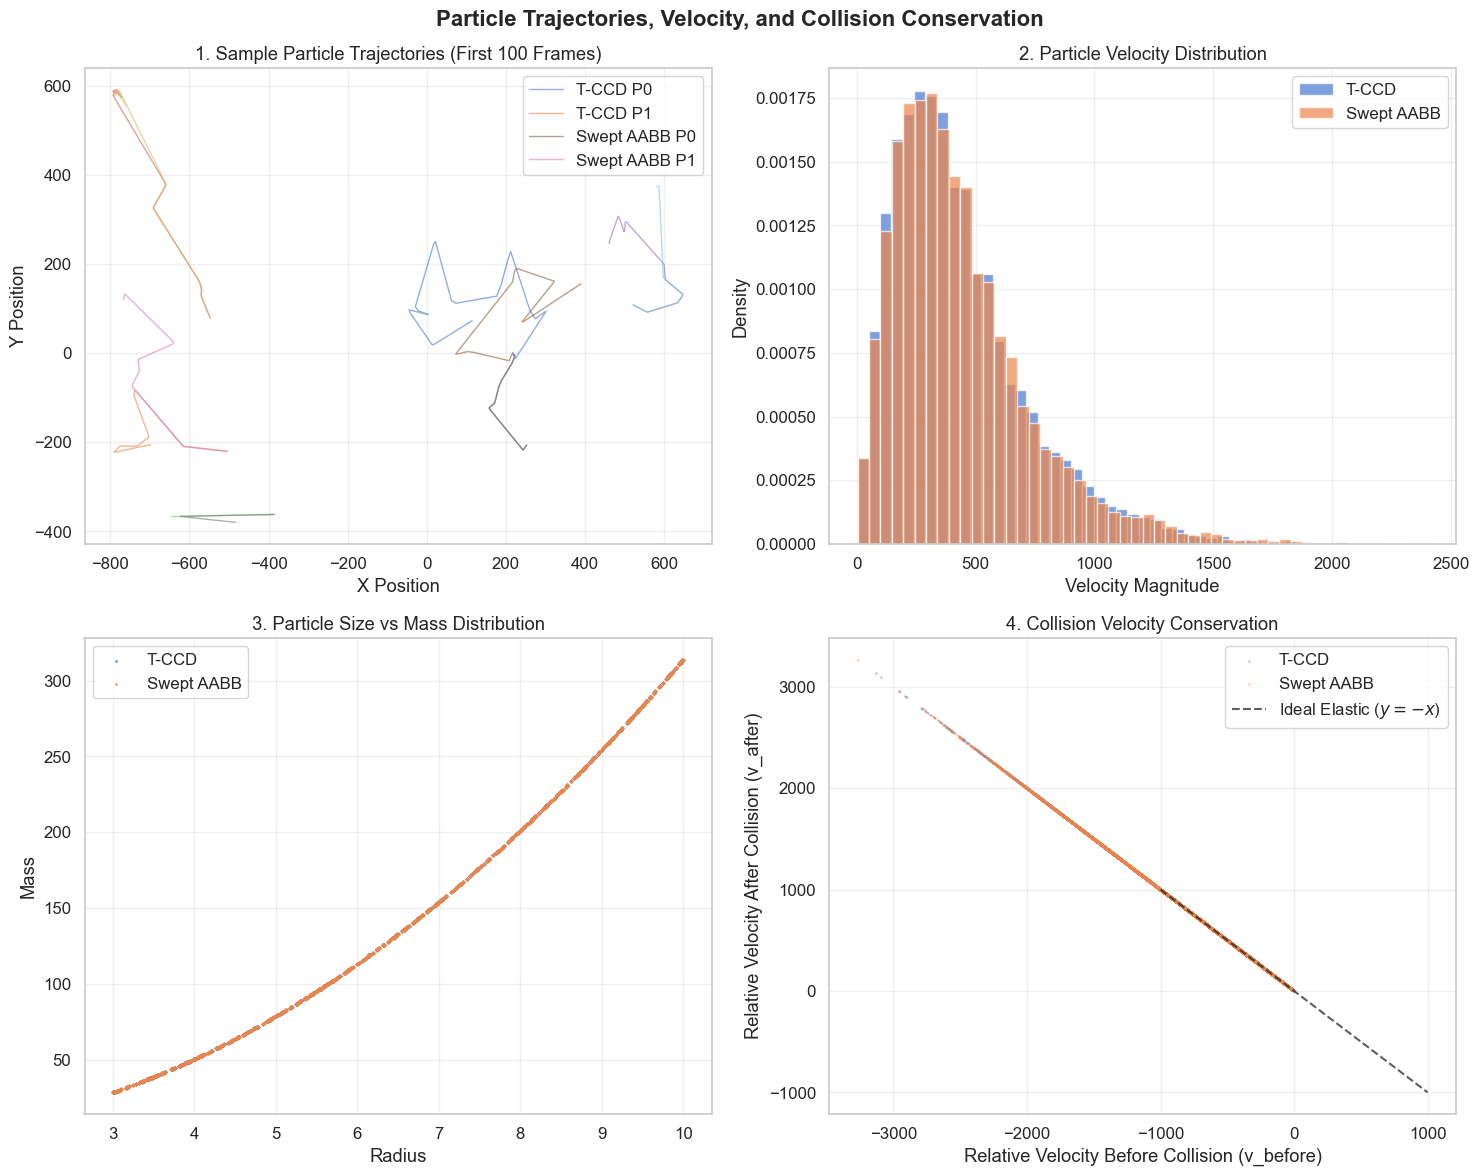

In [45]:
print("=== PARTICLE DYNAMICS ANALYSIS (Plots 1-4) ===")

if not particles_df.empty and not events_df.empty:
    max_frame = 18000
    sample_particles = particles_df[(particles_df['frame'] <= 100) & (particles_df['particle_id'] <= 10)].copy()
    pair_collisions = events_df[events_df['type'] == 'Pair'].copy()

    # 1. Main subplot figure with 4 plots
    fig, axes = plt.subplots(2, 2, figsize=(15, 12)) 
    fig.suptitle('Particle Trajectories, Velocity, and Collision Conservation', fontsize=16, fontweight='bold')

    # --- Plot 1: Particle Trajectories (axes[0,0]) ---
    for algo in ['T-CCD', 'Swept AABB']:
        algo_particles = sample_particles[sample_particles['algorithm'] == algo]
        for pid in range(0, 5):
            particle_traj = algo_particles[algo_particles['particle_id'] == pid]
            if len(particle_traj) > 0:
                axes[0,0].plot(particle_traj['x'], particle_traj['y'], alpha=0.6, linewidth=1, 
                              label=f'{algo} P{pid}' if pid < 2 else "")

    axes[0,0].set_title('1. Sample Particle Trajectories (First 100 Frames)')
    axes[0,0].set_xlabel('X Position')
    axes[0,0].set_ylabel('Y Position')
    axes[0,0].legend()
    axes[0,0].grid(True, alpha=0.3)

    # --- Plot 2: Velocity Distribution (axes[0,1]) ---
    for algo in ['T-CCD', 'Swept AABB']:
        algo_particles = particles_df[particles_df['algorithm'] == algo].sample(
            n=min(10000, len(particles_df[particles_df['algorithm'] == algo])), random_state=42)
        velocity_magnitude = np.sqrt(algo_particles['vx']**2 + algo_particles['vy']**2)
        axes[0,1].hist(velocity_magnitude, bins=50, alpha=0.7, label=algo, density=True)

    axes[0,1].set_title('2. Particle Velocity Distribution')
    axes[0,1].set_xlabel('Velocity Magnitude')
    axes[0,1].set_ylabel('Density')
    axes[0,1].legend()
    axes[0,1].grid(True, alpha=0.3)

    # --- Plot 3: Particle Size and Mass Distribution (axes[1,0]) ---
    for algo in ['T-CCD', 'Swept AABB']:
        algo_particles = particles_df[particles_df['algorithm'] == algo].sample(
            n=min(5000, len(particles_df[particles_df['algorithm'] == algo])), random_state=42)
        axes[1,0].scatter(algo_particles['radius'], algo_particles['mass'], alpha=0.5, s=2, label=algo)

    axes[1,0].set_title('3. Particle Size vs Mass Distribution')
    axes[1,0].set_xlabel('Radius')
    axes[1,0].set_ylabel('Mass')
    axes[1,0].legend()
    axes[1,0].grid(True, alpha=0.3)

    # --- Plot 4: Collision Velocity Analysis (axes[1,1]) ---
    if not pair_collisions.empty and 'vrel_n_before' in pair_collisions.columns and 'vrel_n_after' in pair_collisions.columns:
        collision_velocities = pair_collisions[['vrel_n_before', 'vrel_n_after', 'algorithm']].copy()

        for algo in ['T-CCD', 'Swept AABB']:
            algo_collisions = collision_velocities[collision_velocities['algorithm'] == algo]
            if not algo_collisions.empty:
                sample_size = min(50000, len(algo_collisions))
                algo_sample = algo_collisions.sample(n=sample_size, random_state=42)
                axes[1,1].scatter(algo_sample['vrel_n_before'], algo_sample['vrel_n_after'], 
                                alpha=0.3, s=1, label=algo)

        # Add ideal elastic collision line
        axes[1,1].plot([-1000, 1000], [1000, -1000], 'k--', alpha=0.7, label='Ideal Elastic ($y=-x$)')
        axes[1,1].set_title('4. Collision Velocity Conservation')
        axes[1,1].set_xlabel('Relative Velocity Before Collision (v_before)')
        axes[1,1].set_ylabel('Relative Velocity After Collision (v_after)')
        axes[1,1].legend()
        axes[1,1].grid(True, alpha=0.3)
    else:
        axes[1,1].text(0.5, 0.5, 'Collision velocity data\nnot available', 
                      ha='center', va='center', transform=axes[1,1].transAxes, fontsize=12)
        axes[1,1].set_title('4. Collision Velocity Conservation (No Data)')

    plt.tight_layout()
    plt.show()
else:
    print("❌ Insufficient data for particle dynamics analysis")


=== 5. COLLISION POSITION HEATMAPS ===


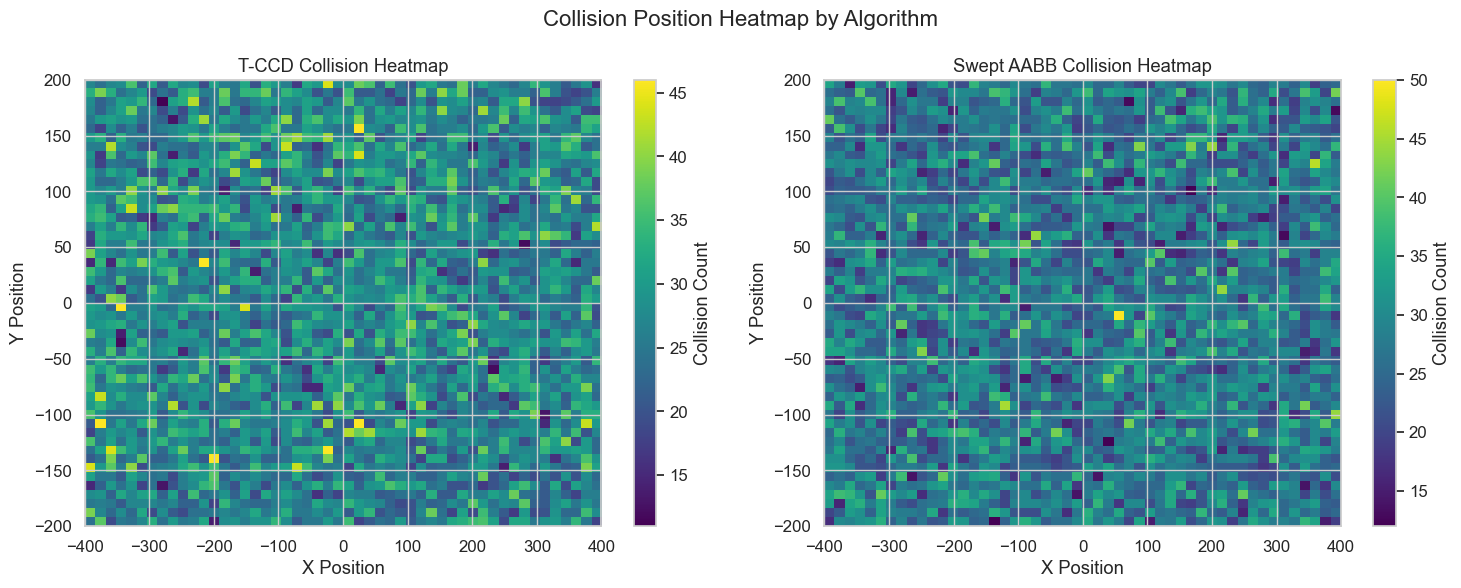

In [46]:
# -------------------------------------------------------------------
# 5. Collision Position Heatmap (Detailed Figure)
# -------------------------------------------------------------------
print("\n=== 5. COLLISION POSITION HEATMAPS ===")

if not events_df.empty and not pair_collisions.empty:
    fig_heatmap, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    fig_heatmap.suptitle('Collision Position Heatmap by Algorithm', fontsize=16)

    for idx, (algo, ax) in enumerate([('T-CCD', ax1), ('Swept AABB', ax2)]):
        algo_positions = pair_collisions[pair_collisions['algorithm'] == algo]
        if not algo_positions.empty and 'ix' in algo_positions.columns and 'iy' in algo_positions.columns:
            heatmap, xedges, yedges = np.histogram2d(
                algo_positions['ix'], 
                algo_positions['iy'],
                bins=[50, 50],
                range=[[-400, 400], [-200, 200]]
            )
            im = ax.imshow(heatmap.T, extent=[-400, 400, -200, 200], origin='lower', 
                           aspect='auto', cmap='viridis')
            ax.set_title(f'{algo} Collision Heatmap')
            ax.set_xlabel('X Position')
            ax.set_ylabel('Y Position')
            fig_heatmap.colorbar(im, ax=ax, label='Collision Count')
        else:
            ax.text(0.5, 0.5, f'No collision position\ndata for {algo}', 
                   ha='center', va='center', transform=ax.transAxes, fontsize=12)
            ax.set_title(f'{algo} Collision Heatmap (No Data)')

    plt.tight_layout()
    plt.show()
else:
    print("❌ No collision events data available for heatmap analysis")


=== 6. TIME OF IMPACT (TOI) ANALYSIS ===


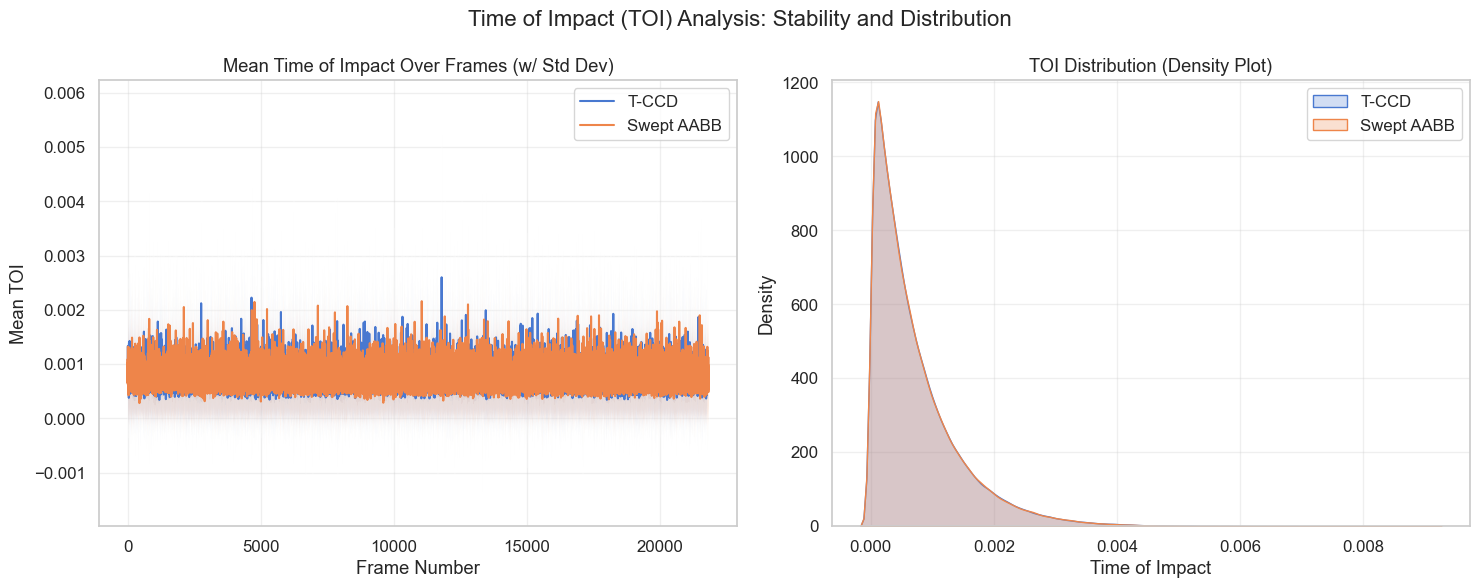

In [47]:
# -------------------------------------------------------------------
# 6. Time of Impact (TOI) Analysis (Detailed Figure)
# -------------------------------------------------------------------
print("\n=== 6. TIME OF IMPACT (TOI) ANALYSIS ===")

if not events_df.empty and not pair_collisions.empty and 'toi' in pair_collisions.columns:
    fig_toi, (ax_toi1, ax_toi2) = plt.subplots(1, 2, figsize=(15, 6))
    fig_toi.suptitle('Time of Impact (TOI) Analysis: Stability and Distribution', fontsize=16)

    # Mean TOI over time
    collision_timing = pair_collisions.groupby(['algorithm', 'frame'])['toi'].agg(['mean', 'std']).reset_index()

    for algo in ['T-CCD', 'Swept AABB']:
        algo_timing = collision_timing[collision_timing['algorithm'] == algo]
        if not algo_timing.empty:
            ax_toi1.plot(algo_timing['frame'], algo_timing['mean'], label=f'{algo}')
            ax_toi1.fill_between(algo_timing['frame'], 
                                algo_timing['mean'] - algo_timing['std'],
                                algo_timing['mean'] + algo_timing['std'],
                                alpha=0.2)

    ax_toi1.set_title('Mean Time of Impact Over Frames (w/ Std Dev)')
    ax_toi1.set_xlabel('Frame Number')
    ax_toi1.set_ylabel('Mean TOI')
    ax_toi1.legend()
    ax_toi1.grid(True, alpha=0.3)

    # TOI Distribution
    for algo in ['T-CCD', 'Swept AABB']:
        algo_collisions = pair_collisions[pair_collisions['algorithm'] == algo]
        if not algo_collisions.empty and 'toi' in algo_collisions.columns:
            sns.kdeplot(data=algo_collisions['toi'], ax=ax_toi2, label=algo, fill=True)

    ax_toi2.set_title('TOI Distribution (Density Plot)')
    ax_toi2.set_xlabel('Time of Impact')
    ax_toi2.set_ylabel('Density')
    ax_toi2.legend()
    ax_toi2.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()
else:
    print("❌ No TOI data available for analysis")

In [48]:
# -------------------------------------------------------------------
# Statistical Printouts and Physics Validation
# -------------------------------------------------------------------

print("\n=== PHYSICS VALIDATION (Energy Conservation) ===")

if not pair_collisions.empty and 'vrel_n_before' in pair_collisions.columns and 'vrel_n_after' in pair_collisions.columns:
    for algo in ['T-CCD', 'Swept AABB']:
        algo_collisions = pair_collisions[pair_collisions['algorithm'] == algo]
        if not algo_collisions.empty:
            # Calculate velocity ratio for energy conservation analysis
            before_vel = algo_collisions['vrel_n_before'].abs()
            after_vel = algo_collisions['vrel_n_after'].abs()
            
            # Avoid division by zero
            valid_mask = (before_vel > 1e-10) & (after_vel.notna()) & (before_vel.notna())
            velocity_ratio = after_vel[valid_mask] / before_vel[valid_mask]
            
            if len(velocity_ratio) > 0:
                print(f"\n{algo}:")
                print(f"  • Energy conservation ratio (|v_after|/|v_before|):")
                print(f"    - Mean: {velocity_ratio.mean():.4f}")
                print(f"    - Std: {velocity_ratio.std():.4f}")
                print(f"    - % near perfect (0.95-1.05): {((velocity_ratio >= 0.95) & (velocity_ratio <= 1.05)).mean()*100:.1f}%")
                print(f"    - Valid collision samples: {len(velocity_ratio):,}")
            else:
                print(f"\n{algo}: No valid velocity data for energy conservation analysis")
else:
    print("❌ No collision velocity data available for energy conservation analysis")

print("\n=== TIME OF IMPACT (TOI) STATISTICS ===")

if not pair_collisions.empty and 'toi' in pair_collisions.columns:
    for algo in ['T-CCD', 'Swept AABB']:
        algo_collisions = pair_collisions[pair_collisions['algorithm'] == algo]
        if not algo_collisions.empty and 'toi' in algo_collisions.columns:
            toi_data = algo_collisions['toi'].dropna()
            if len(toi_data) > 0:
                print(f"\n{algo}:")
                print(f"  • Mean TOI: {toi_data.mean():.6f}")
                print(f"  • TOI Std Dev: {toi_data.std():.6f}")
                print(f"  • TOI Range: {toi_data.min():.6f} to {toi_data.max():.6f}")
                print(f"  • TOI samples: {len(toi_data):,}")
            else:
                print(f"\n{algo}: No valid TOI data")
else:
    print("❌ No TOI data available for analysis")

print(f"\n=== PARTICLE DISTRIBUTION CHECK ===")

if not particles_df.empty:
    for algo in ['T-CCD', 'Swept AABB']:
        algo_particles = particles_df[particles_df['algorithm'] == algo]
        if not algo_particles.empty:
            print(f"\n{algo}:")
            print(f"  • Position bounds: X[{algo_particles['x'].min():.1f}, {algo_particles['x'].max():.1f}], Y[{algo_particles['y'].min():.1f}, {algo_particles['y'].max():.1f}]")
            print(f"  • Velocity bounds: Vx[{algo_particles['vx'].min():.2f}, {algo_particles['vx'].max():.2f}], Vy[{algo_particles['vy'].min():.2f}, {algo_particles['vy'].max():.2f}]")
            print(f"  • Particle records: {len(algo_particles):,}")
            print(f"  • Unique particles: {algo_particles['particle_id'].nunique():,}")
            
            # Physical properties analysis
            if 'radius' in algo_particles.columns and 'mass' in algo_particles.columns:
                print(f"  • Radius range: [{algo_particles['radius'].min():.3f}, {algo_particles['radius'].max():.3f}]")
                print(f"  • Mass range: [{algo_particles['mass'].min():.3f}, {algo_particles['mass'].max():.3f}]")
else:
    print("❌ No particle data available for distribution analysis")

print(f"\n=== COLLISION EVENT SUMMARY ===")

if not events_df.empty:
    print(f"Total collision events: {len(events_df):,}")
    print(f"Event types: {events_df['type'].value_counts().to_dict()}")
    
    for algo in ['T-CCD', 'Swept AABB']:
        algo_events = events_df[events_df['algorithm'] == algo]
        if not algo_events.empty:
            print(f"\n{algo} Events:")
            print(f"  • Total events: {len(algo_events):,}")
            print(f"  • Event breakdown: {algo_events['type'].value_counts().to_dict()}")
            print(f"  • Frame range: {algo_events['frame'].min()} to {algo_events['frame'].max()}")
else:
    print("❌ No event data available")

print("\n✅ Particle dynamics analysis complete!")


=== PHYSICS VALIDATION (Energy Conservation) ===

T-CCD:
  • Energy conservation ratio (|v_after|/|v_before|):
    - Mean: 1.0000
    - Std: 0.0000
    - % near perfect (0.95-1.05): 100.0%
    - Valid collision samples: 397,251

Swept AABB:
  • Energy conservation ratio (|v_after|/|v_before|):
    - Mean: 1.0000
    - Std: 0.0000
    - % near perfect (0.95-1.05): 100.0%
    - Valid collision samples: 398,309

=== TIME OF IMPACT (TOI) STATISTICS ===

T-CCD:
  • Mean TOI: 0.000727
  • TOI Std Dev: 0.000725
  • TOI Range: 0.000000 to 0.008922
  • TOI samples: 397,251

Swept AABB:
  • Mean TOI: 0.000725
  • TOI Std Dev: 0.000725
  • TOI Range: 0.000000 to 0.009103
  • TOI samples: 398,309

=== PARTICLE DISTRIBUTION CHECK ===

T-CCD:
  • Position bounds: X[-797.0, 797.0], Y[-597.0, 597.0]
  • Velocity bounds: Vx[-2795.20, 3306.37], Vy[-2749.76, 2986.61]
  • Particle records: 10,875,950
  • Unique particles: 500
  • Radius range: [3.004, 9.996]
  • Mass range: [28.342, 313.881]

Swept AABB:

## 6. Collision Detection Accuracy Analysis  (Proportion Z-Test)

The Proportion Z-Test is a statistical method used to compare the success rates of two systems based on a binary outcome, including whether a collision was correctly detected or not. In this study, it will be employed to assess whether the T-CCD system statistically outperforms the Time of Impact method in terms of collision detection accuracy.

Specifically, it compares the collision detection success rate and the false negative rate (i.e., missed collisions) between the two systems. The test evaluates whether the observed difference in proportions is statistically significant or simply due to chance.

**The formula for the Z-test is given by:**

$$Z = \frac{p_1 - p_2}{\sqrt{p(1-p)\left(\frac{1}{n_1} + \frac{1}{n_2}\right)}}$$

**Where:**
- $p_1$ and $p_2$ are the sample proportions of success in group 1 (T-CCD) and group 2 (TOI-CCD), respectively
- $n_1$ and $n_2$ are the sample sizes of the two groups, $n$ = true positive + false negative
- $p$ is the pooled proportion of success rate: $p = \frac{x_1 + x_2}{n_1 + n_2}$

In [51]:
import numpy as np
from scipy import stats
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def two_proportion_z_test(tp1, fn1, tp2, fn2, alpha=0.05):

    n1 = tp1 + fn1 # #True Positives + False Negatives
    n2 = tp2 + fn2 # #True Positives + False Negatives
    if n1 == 0 or n2 == 0:
        raise ValueError("n1 and n2 must be > 0")
    
    p1 = tp1 / n1
    p2 = tp2 / n2

    
    # Pooled proportion
    p_pooled = (tp1 + tp2) / (n1 + n2)
    
    # Standard error
    se = np.sqrt(p_pooled * (1 - p_pooled) * (1/n1 + 1/n2))
    if se  == 0:
        raise ValueError("Pooled standard error is zero (degenerate). Check inputs.")
    
    # Z-statistic
    z_stat = (p1 - p2) / se
    
    # Two-tailed p-value
    p_value = 2 * (1 - stats.norm.cdf(abs(z_stat)))
    
    # Confidence interval for difference in proportions
    se_diff = np.sqrt((p1 * (1-p1)/n1) + (p2 * (1-p2)/n2))
    z_crit = stats.norm.ppf(1 - alpha/2)
    diff = p1 - p2
    ci = (p1 - p2 - z_crit * se_diff,
          p1 - p2 + z_crit * se_diff)
    
    return {
        'p1': p1,
        'p2': p2,
        'diff': p1 - p2,
        'z_stat': z_stat,
        'p_value': p_value,
        'ci_lower': ci[0],
        'ci_upper': ci[1]
    }


print("=== HYPOTHESIS 1: ACCURACY COMPARISON ===\n")


tccd_frame_data = tccd_events_df[tccd_events_df['frame'] <= 18000]
swept_frame_data = swept_aabb_events_df[swept_aabb_events_df['frame'] <= 18000]

#From the simulator
tccd_tp = 394885
tccd_fp = 2
tccd_fn = 4335
swept_tp = 394682
swept_fp = 2
swept_fn = 4445

z_test = two_proportion_z_test(tccd_tp, tccd_fn, swept_tp, swept_fn)

print("Accuracy Analysis (True Positive Rate)")
print("-" * 50)
print(f"T-CCD TP Rate: {z_test['p1']:.4%}")
print(f"Swept AABB TP Rate: {z_test['p2']:.4%}")
print(f"Difference: {z_test['diff']:.4%}")
print(f"95% CI: [{z_test['ci_lower']:.4%}, {z_test['ci_upper']:.4%}]")
print(f"Z-statistic: {z_test['z_stat']:.4f}")
print(f"P-value: {z_test['p_value']:.4e}")
print(f"Statistical Significance: {'Significant' if z_test['p_value'] < 0.05 else 'Not Significant'}")


=== HYPOTHESIS 1: ACCURACY COMPARISON ===

Accuracy Analysis (True Positive Rate)
--------------------------------------------------
T-CCD TP Rate: 98.9141%
Swept AABB TP Rate: 98.8863%
Difference: 0.0278%
95% CI: [-0.0179%, 0.0736%]
Z-statistic: 1.1914
P-value: 2.3349e-01
Statistical Significance: Not Significant


## 7. Welch's T-Test Analysis

## Hypotheses

**Null Hypothesis (H₀):** There is no significant difference between the T-CCD simulator and the TOI-CCD method regarding simulation accuracy, computational cost, memory usage, and CPU load.

**Alternative Hypothesis (H₁):** The T-CCD simulator performs significantly better than the TOI-CCD for simulation accuracy, computational cost, memory usage, and CPU load.

We use Welch's t-test to evaluate whether T-CCD method shows significantly different performance metrics compared to the traditional TOI-CCD (Swept AABB) method. This statistical test accounts for potentially unequal variances between the two methods and is appropriate for continuous data from independent samples.


=== HYPOTHESIS 2: PERFORMANCE COMPARISON ===

Computation Time Analysis
--------------------------------------------------
T-CCD Mean Time: 150.126326 seconds
Swept AABB Mean Time: 150.532035 seconds
Difference: -0.405710 seconds
95% CI: [-0.788426, -0.022993]
T-statistic: -2.0777
P-value: 3.7735e-02
Effect Size (Cohen's d): -0.0047
Statistical Significance: Significant


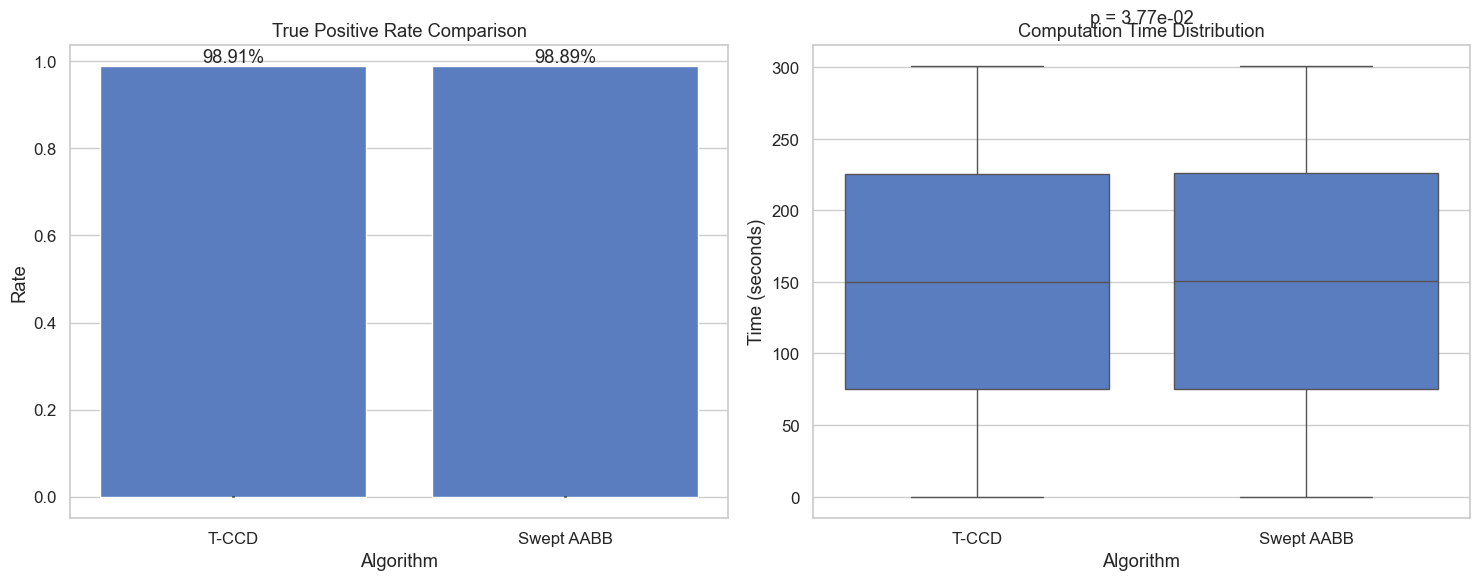

In [50]:
def welch_t_test(data1, data2, alpha=0.05, alternative='two-sided'):

    t_stat, p_value = stats.ttest_ind(data1, data2, equal_var=False)
    
   
    mean1, std1 = np.mean(data1), np.std(data1, ddof=1)
    mean2, std2 = np.mean(data2), np.std(data2, ddof=1)
    

    df = len(data1) + len(data2) - 2 
    se = np.sqrt(std1**2/len(data1) + std2**2/len(data2))
    ci = (mean1 - mean2 - stats.t.ppf(1-alpha/2, df) * se,
          mean1 - mean2 + stats.t.ppf(1-alpha/2, df) * se)
    
    # Effect size (Cohen's d)
    pooled_std = np.sqrt(((len(data1)-1) * std1**2 + (len(data2)-1) * std2**2) / df)
    cohens_d = (mean1 - mean2) / pooled_std
    
    return {
        'mean1': mean1,
        'mean2': mean2,
        'diff': mean1 - mean2,
        't_stat': t_stat,
        'p_value': p_value,
        'ci_lower': ci[0],
        'ci_upper': ci[1],
        'cohens_d': cohens_d
    }



print("\n=== HYPOTHESIS 2: PERFORMANCE COMPARISON ===\n")

# Test for computation time
time_test = welch_t_test(tccd_frame_data['time_s'].values, swept_frame_data['time_s'].values)

print("Computation Time Analysis")
print("-" * 50)
print(f"T-CCD Mean Time: {time_test['mean1']:.6f} seconds")
print(f"Swept AABB Mean Time: {time_test['mean2']:.6f} seconds")
print(f"Difference: {time_test['diff']:.6f} seconds")
print(f"95% CI: [{time_test['ci_lower']:.6f}, {time_test['ci_upper']:.6f}]")
print(f"T-statistic: {time_test['t_stat']:.4f}")
print(f"P-value: {time_test['p_value']:.4e}")
print(f"Effect Size (Cohen's d): {time_test['cohens_d']:.4f}")
print(f"Statistical Significance: {'Significant' if time_test['p_value'] < 0.05 else 'Not Significant'}")

# Visualization of results
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# 1. True Positive Rate Comparison
tp_data = pd.DataFrame({
    'Algorithm': ['T-CCD', 'Swept AABB'],
    'True Positive Rate': [z_test['p1'], z_test['p2']],
    'CI Lower': [z_test['p1'] - (z_test['p1'] - z_test['ci_lower']),
                z_test['p2'] - (z_test['p2'] - (z_test['ci_lower'] + z_test['diff']))],
    'CI Upper': [z_test['p1'] + (z_test['ci_upper'] - z_test['p1']),
                z_test['p2'] + (z_test['ci_upper'] - z_test['diff'] - z_test['p2'])]
})

sns.barplot(data=tp_data, x='Algorithm', y='True Positive Rate', ax=ax1)
ax1.set_title('True Positive Rate Comparison')
ax1.set_ylabel('Rate')

# Add confidence intervals
for i, row in tp_data.iterrows():
    ax1.vlines(i, row['CI Lower'], row['CI Upper'], color='black', linestyle='-', lw=2)
    ax1.text(i, row['True Positive Rate'], f"{row['True Positive Rate']:.2%}", 
             ha='center', va='bottom')

# 2. Computation Time Comparison
# Create combined dataframe for boxplot
time_comparison_df = pd.concat([
    tccd_frame_data[['time_s']].assign(algorithm='T-CCD'),
    swept_frame_data[['time_s']].assign(algorithm='Swept AABB')
], ignore_index=True)

sns.boxplot(data=time_comparison_df, x='algorithm', y='time_s', ax=ax2)
ax2.set_title('Computation Time Distribution')
ax2.set_xlabel('Algorithm')
ax2.set_ylabel('Time (seconds)')

# Add statistical significance annotations
if time_test['p_value'] < 0.05:
    y_max = max(tccd_frame_data['time_s'].max(), swept_frame_data['time_s'].max())
    ax2.text(0.5, y_max*1.1, f"p = {time_test['p_value']:.2e}", ha='center')

plt.tight_layout()
plt.show()